# Twitter Bot Detection
The aim of this code is to create a model to predict the probability of a twitter account being a bot.
While there are useful bots (eg.bots to automate repetitive processes like providing daily weather forecast), the presence of bots with negative behaviour are often more common and costs more to the society (eg. spam bots, bots spreading misinformation/malicious content). Hence, having an accurate model to predict bot accounts will be able to speed up platform moderator's workload and effectively reduce the number of harmful bots. It is important to note that no models are perfect, so human moderators are still needed in the loop to verify model predictions and pick up wrongly classified cases.

The overall workflow was: EDA -> Data Cleaning -> Feature Engineering -> Train Models (5 were chosen: Logistic Regression, Random Forest, XGBoost, LightGBM, Stacking Ensemble) -> Choose best model based on results

XGBoost was chosen as the final model as it has the highest ROC-AUC, which measures the model's ability to discriminate between non bots and bots.

My takeaways from this practice is that good feature engineering and hyperparameter tuning can drastically improve model performance. EDA is important to observe and understand the data in order to come up with good features. Stacking models may not always be helpful when one model is already able to capture most data patterns, adding other models may just introduce noise. This is also my first time training models with text data ('description' field)

In [18]:
import numpy as np
import pandas as pd 

In [19]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Data Cleaning

In [20]:
def clean_features(df):
    df['description'] = df['description'].fillna('')
    df['lang'] = df['lang'].fillna('missing')
    df['location'] = df['location'].fillna('unknown')
    df['profile_image_url'] = df['profile_image_url'].fillna('')
    return df
df_train = clean_features(df_train)
df_test = clean_features(df_test)

# Feature Engineering
The following features are engineered based on hypotheses about differences in accounts between bots and humans <br><br>


In [21]:
import re

def engineer_bot_features(df):
    """Feature engineering pipeline for Twitter bot detection."""
    
    # ====== BASIC RATIO FEATURES ======
    # Bots may have more extreme values. eg Much more posts than friends/followers, causing large statuses_to_followers/friends ratios.
    df['friends_to_followers'] = df['friends_count'] / (df['followers_count'] + 1)
    df['favourites_per_day'] = df['favourites_count'] / (df['account_age_days'] + 1)
    df['favourites_per_tweet'] = df['favourites_count'] / (df['statuses_count'] + 1)
    df['statuses_to_followers'] = df['statuses_count'] / (df['followers_count'] + 1)
    df['statuses_to_friends'] = df['statuses_count'] / (df['friends_count'] + 1)
    df['statuses_to_favourites'] = df['statuses_count'] / (df['favourites_count'] + 1)
    df['friends_per_day'] = df['friends_count'] / (df['account_age_days'] + 1)
    df['followers_per_day'] = df['followers_count'] / (df['account_age_days'] + 1)
    df['favourites_followers'] = df['favourites_count'] / (df['followers_count'] + 1)
    df['favourites_friends'] = df['favourites_count'] / (df['friends_count'] + 1)
    df['follower_friends_days'] = (df['friends_count'] + df['followers_count']) / (df['account_age_days'] + 1)
    df['favourites_status_days'] = (df['favourites_count'] + df['statuses_count']) / (df['account_age_days'] + 1)
    df['id_acc_age'] = df['id'].astype(float) * df['account_age_days'].astype(float)

    def mark_extremes(df, col, lower_quantile=0.01, upper_quantile=0.99):
        """
        Flags values below the lower quantile or above the upper quantile as suspicious (1), else 0.
        """
        lower = df[col].quantile(lower_quantile)
        upper = df[col].quantile(upper_quantile)
        return ((df[col] < lower) | (df[col] > upper)).astype(int)
    
    # ====== TEXT FEATURES ======
    # Bots may have a shorter description than human users, in order to simplify bot creation process.
    df['num_links'] = df['description'].str.count('https://t.co/')
    df['description_len'] = df['description'].str.len()
    
    # ====== PROFILE FLAGS ======
    # Bots are more likely to have default profiles, and empty location and language to save effort on account creation
    # Bots are more likely to have the word 'bot' or 'robot' in their description
    df['known_location'] = df['location'].str.lower() != 'unknown'
    df['has_lang'] = df['lang'].str.lower() != 'missing'
    df['contains_bot'] = df['description'].str.lower().str.contains(
        r'\b(?:bot|bots|robot|robots)\b[.,!?:;]?', na=False
    )
    
    # ====== BACKGROUND THEME ======
    # Bots are more likely to have theme 1 compared to other themes
    # Bots are more likely to have profile image url ending with jpeg and png compared to human users
    df['profile_bg_theme'] = df['profile_background_image_url'].str.extract(r'theme(\d+)').squeeze()
    df['profile_bg_theme'] = df['profile_bg_theme'].fillna(0).astype(int)
    df['profile_bg_theme_grouped'] = df['profile_bg_theme'].replace({i: 2 for i in range(2, 21)})
    df['profile_image_url_len'] = df['profile_image_url'].str.len()
    ext = df['profile_image_url'].str.extract(r'\.(jpg|jpeg|png)$', flags=re.IGNORECASE)[0].fillna('other')
    df['profile_img_ext'] = ext.str.lower().where(ext.str.lower().isin(['jpg','jpeg','png']), 'other')

    
    # ====== TEMPORAL FEATURES ======
    # Bot accounts may be created at timings where humans are usually not awake
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    df['account_creation_hour'] = df['created_at'].dt.hour
        
    # ====== PROFILE COMPLETENESS ======
    df['profile_completeness'] = (
        (~df['default_profile']).astype(int) +
        (~df['default_profile_image']).astype(int) +
        df['verified'].astype(int) +
        df['geo_enabled'].astype(int) +
        df['known_location'].astype(int) +
        df['has_lang'].astype(int) +
        (df['description_len'] > 20).astype(int) +
        (df['profile_image_url_len'] > 0).astype(int)
    )
    
    # ====== LOG-TRANSFORM SKEWED FEATURES ======
    skewed_features = [
        'friends_to_followers', 'favourites_per_day', 'favourites_per_tweet',
        'statuses_to_followers', 'statuses_to_friends', 'statuses_to_favourites',
        'friends_per_day', 'followers_per_day', 'friends_count', 'favourites_count',
        'followers_count', 'statuses_count', 'account_age_days', 'favourites_followers',
        'favourites_friends', 'follower_friends_days', 'average_tweets_per_day',
        'favourites_status_days','id_acc_age'
    ]
    
    for col in skewed_features:
        df[f'log_{col}'] = np.log1p(df[col])
        
    lower_q = 0.01
    upper_q = 0.99
    
    for col in skewed_features:
        lower = df[col].quantile(lower_q)
        upper = df[col].quantile(upper_q)
        df[f'extreme_{col}'] = ((df[col] < lower) | (df[col] > upper)).astype(int)

    # ====== BOT SUSPICION SCORE ======
    df['bot_suspicion_score'] = (
        (df['default_profile']).astype(int) * 2 +
        (df['default_profile_image']).astype(int) * 2 +
        (df['favourites_count'] == 0).astype(int) +
        (df['statuses_count'] == 0).astype(int) +
        (~df['geo_enabled']).astype(int) +
        (~df['verified']).astype(int) +
        (df['description_len'] < 10).astype(int) +
        df['contains_bot'].astype(int) * 3 +
        df[[c for c in df.columns if c.startswith('extreme_')]].sum(axis=1)  # aggregate all extreme features
    )
    
    return df

df_train = engineer_bot_features(df_train)
df_test = engineer_bot_features(df_test)

In [22]:
from sklearn.model_selection import StratifiedKFold
from category_encoders import TargetEncoder

# ====== Reset index ======
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# ====== Initialize out-of-fold arrays ======
oof_lang_logit = np.zeros(len(df_train))
oof_location_te = np.zeros(len(df_train))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ====== Global base rate for logit (for LANG) ======
global_mean = df_train['target'].mean()
global_logit = np.log(global_mean / (1 - global_mean))
k = 10  # smoothing for LANG

# ====== CV loop ======
for train_idx, val_idx in skf.split(df_train, df_train['target']):
    train_fold = df_train.iloc[train_idx]
    val_fold = df_train.iloc[val_idx]
    
    # ====== LANG Bayesian-smoothed log-odds ======
    lang_stats = train_fold.groupby('lang')['target'].agg(['mean', 'count'])
    lang_stats['smoothed'] = (lang_stats['mean'] * lang_stats['count'] + global_mean * k) / (lang_stats['count'] + k)
    lang_stats['logit'] = np.log((lang_stats['smoothed'] + 1e-6) / (1 - lang_stats['smoothed'] + 1e-6)) - global_logit
    oof_lang_logit[val_idx] = val_fold['lang'].map(lang_stats['logit']).fillna(0)
    
    # ====== LOCATION Target Encoding ======
    te = TargetEncoder(smoothing=0.2)
    te.fit(train_fold['location'], train_fold['target'])
    oof_location_te[val_idx] = te.transform(val_fold['location']).values.ravel()

# ====== Store out-of-fold features ======
df_train['lang_bot_prob'] = oof_lang_logit
df_train['location_te'] = oof_location_te

# ====== Fit on full training set for test set transformation ======
te_full = TargetEncoder(smoothing=0.2)
te_full.fit(df_train['location'], df_train['target'])
df_test['location_te'] = te_full.transform(df_test['location']).values.ravel()

# ====== LANG full training for test set ======
lang_stats_full = df_train.groupby('lang')['target'].agg(['mean', 'count'])
lang_stats_full['smoothed'] = (lang_stats_full['mean'] * lang_stats_full['count'] + global_mean * k) / (lang_stats_full['count'] + k)
lang_stats_full['logit'] = np.log((lang_stats_full['smoothed'] + 1e-6) / (1 - lang_stats_full['smoothed'] + 1e-6)) - global_logit
df_test['lang_bot_prob'] = df_test['lang'].map(lang_stats_full['logit']).fillna(0)

# Note: location_te is not used in the model as it doesnt help to improve the predictions.

# TF-IDF + SVD for description

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
df_train['description_raw'] = df_train['description'].astype(str).fillna('')
df_test['description_raw'] = df_test['description'].astype(str).fillna('')

def custom_preprocessor(text):
    text = re.sub(r'https?://t\.co/\w+|https?://\S+', ' <URL_TCO> ', text)
    text = re.sub(r'ðŸ\w+?|â\w+?|ð\w+?|âœ\w+?|ð\w+|ã\w+|Ø\w+|è\w+|ñ\w+', ' ', text)
    text = re.sub(r'[^\w\s\<\>]+', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_train['description_clean'] = df_train['description_raw'].apply(custom_preprocessor)
df_test['description_clean'] = df_test['description_raw'].apply(custom_preprocessor)

def calculate_non_ascii_features(text):
    text = str(text)
    length = len(text)
    if length == 0:
        return 0.0, 0.0
    non_ascii_count = len(re.findall(r'[^\x00-\x7F]', text))
    symbol_count = len(re.findall(r'[^\w\s]', text))
    non_ascii_ratio = non_ascii_count / length
    symbol_ratio = symbol_count / length
    return non_ascii_ratio, symbol_ratio

df_train['desc_non_ascii_ratio'], df_train['desc_symbol_ratio'] = zip(*df_train['description_raw'].apply(calculate_non_ascii_features))
df_test['desc_non_ascii_ratio'], df_test['desc_symbol_ratio'] = zip(*df_test['description_raw'].apply(calculate_non_ascii_features))

df_train['description_missing'] = df_train['description'].isnull().astype(int)
df_test['description_missing'] = df_test['description'].isnull().astype(int)

description_counts = df_train['description_raw'].value_counts()
df_train['description_frequency'] = df_train['description_raw'].map(description_counts)
df_test['description_frequency'] = df_test['description_raw'].map(description_counts).fillna(1).astype(int)

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,3),
    stop_words='english',
    preprocessor=custom_preprocessor,
    min_df=5
)

X_train_tfidf = tfidf.fit_transform(df_train['description_clean'])
X_test_tfidf = tfidf.transform(df_test['description_clean'])

N_COMPONENTS = 70
svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)
    
desc_cols = [f'desc_svd_{i}' for i in range(N_COMPONENTS)]
df_train_svd = pd.DataFrame(X_train_svd, columns=desc_cols, index=df_train.index)
df_test_svd = pd.DataFrame(X_test_svd, columns=desc_cols, index=df_test.index)

structural_features = ['description_missing', 'description_frequency']
non_ascii_features = ['desc_non_ascii_ratio', 'desc_symbol_ratio']


In [24]:
from collections import Counter

# ====== 1. Separate bots and humans ======
bots = df_train[df_train['target']==1]      # 1 = bot
humans = df_train[df_train['target']==0]    # 0 = human

bot_descriptions = bots['description'].dropna().str.lower()
human_descriptions = humans['description'].dropna().str.lower()

# ====== 2. Preprocess text ======
def preprocess(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-z\s]', '', text) # keep letters only
    return text.split()

bot_tokens = [token for desc in bot_descriptions for token in preprocess(desc)]
human_tokens = [token for desc in human_descriptions for token in preprocess(desc)]

# ====== 3. Count word frequencies ======
bot_counter = Counter(bot_tokens)
human_counter = Counter(human_tokens)

# ====== 4. Compute ratio of bot vs human usage ======
bot_df = pd.DataFrame(bot_counter.items(), columns=['word', 'bot_count'])
human_df = pd.DataFrame(human_counter.items(), columns=['word', 'human_count'])
merged = pd.merge(bot_df, human_df, on='word', how='outer').fillna(0)

# ====== 5. Add ratio (bots/humans) ======
merged['ratio'] = (merged['bot_count'] + 1) / (merged['human_count'] + 1)

# Top 10 words most indicative of bots
top_bot_words = merged.sort_values('ratio', ascending=False).head(8)
print("Top bot-like words:\n", top_bot_words[['word','ratio']])

bot_keywords = top_bot_words['word'].tolist()

# ====== 6. Create features for your model ======
for word in bot_keywords:
    df_train[f'botword_{word}'] = df_train['description'].fillna('').str.lower().str.contains(word).astype(int)
    df_test[f'botword_{word}'] = df_test['description'].fillna('').str.lower().str.contains(word).astype(int)


Top bot-like words:
           word      ratio
4989       bot  48.600000
17409  harshly  47.000000
4992   botally  23.000000
42557  waiting  13.818182
36063   slowly  13.750000
15939   gently  13.666667
8700   cosplay  12.857143
18466   hugovk  12.000000


# Preparing Features for testing

In [25]:
bool_cols = ['geo_enabled', 'verified', 'known_location', 'has_lang', 'contains_bot']

df_train[bool_cols] = df_train[bool_cols].astype(int)
df_test[bool_cols] = df_test[bool_cols].astype(int)

df_train = pd.get_dummies(df_train, columns=['profile_bg_theme_grouped'], prefix='bg_theme', drop_first=False)
df_train = pd.get_dummies(df_train, columns=['profile_img_ext'], prefix='ext_', drop_first=False)
df_test = pd.get_dummies(df_test, columns=['profile_bg_theme_grouped'], prefix='bg_theme', drop_first=False)
df_test = pd.get_dummies(df_test, columns=['profile_img_ext'], prefix='ext_', drop_first=False)

In [26]:
from sklearn.model_selection import train_test_split
bot_word_cols = [f'botword_{w}' for w in bot_keywords]

bg_theme_cols = [col for col in df_train.columns if col.startswith('bg_theme_')]
ext_cols = [col for col in df_train.columns if col.startswith('ext_')]

feature_cols = [
    'default_profile',
    'default_profile_image',
    'friends_to_followers',
    'log_friends_to_followers',
    'log_favourites_per_day',
    'log_favourites_per_tweet',
    'log_statuses_to_followers',
    'log_statuses_to_friends',
    'log_statuses_to_favourites',
    'log_friends_per_day',
    'log_followers_per_day',
    'log_friends_count',
    'log_statuses_count',
    'log_favourites_count',
    'log_followers_count',
    'account_age_days',
    'average_tweets_per_day',
    'log_favourites_friends', 
    'log_follower_friends_days',
    'log_favourites_status_days',
    'profile_image_url_len',
    'lang_bot_prob',
    'geo_enabled',
    'verified',
    'known_location',
    'has_lang',                
    'num_links',                
    'description_len',                      
    'account_creation_hour',   
    'contains_bot',
    'extreme_friends_to_followers',
    'extreme_favourites_per_day',
    'extreme_favourites_per_tweet',
    'extreme_statuses_to_followers',
    'extreme_statuses_to_friends',
    'extreme_statuses_to_favourites',
    'extreme_friends_per_day',
    'extreme_followers_per_day',
    'extreme_friends_count',
    'extreme_favourites_count',
    'extreme_followers_count',
    'extreme_statuses_count',
    'extreme_account_age_days',
    'extreme_favourites_followers',
    'extreme_favourites_friends',
    'extreme_follower_friends_days',
    'extreme_average_tweets_per_day',
    'extreme_favourites_status_days',
    'profile_completeness',
    'bot_suspicion_score',
    'log_id_acc_age'
] 

feature_cols_train = feature_cols + bg_theme_cols + bot_word_cols + ext_cols + structural_features + non_ascii_features

X = pd.concat([df_train[feature_cols_train], df_train_svd], axis=1)

y = df_train['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42, stratify = y)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()


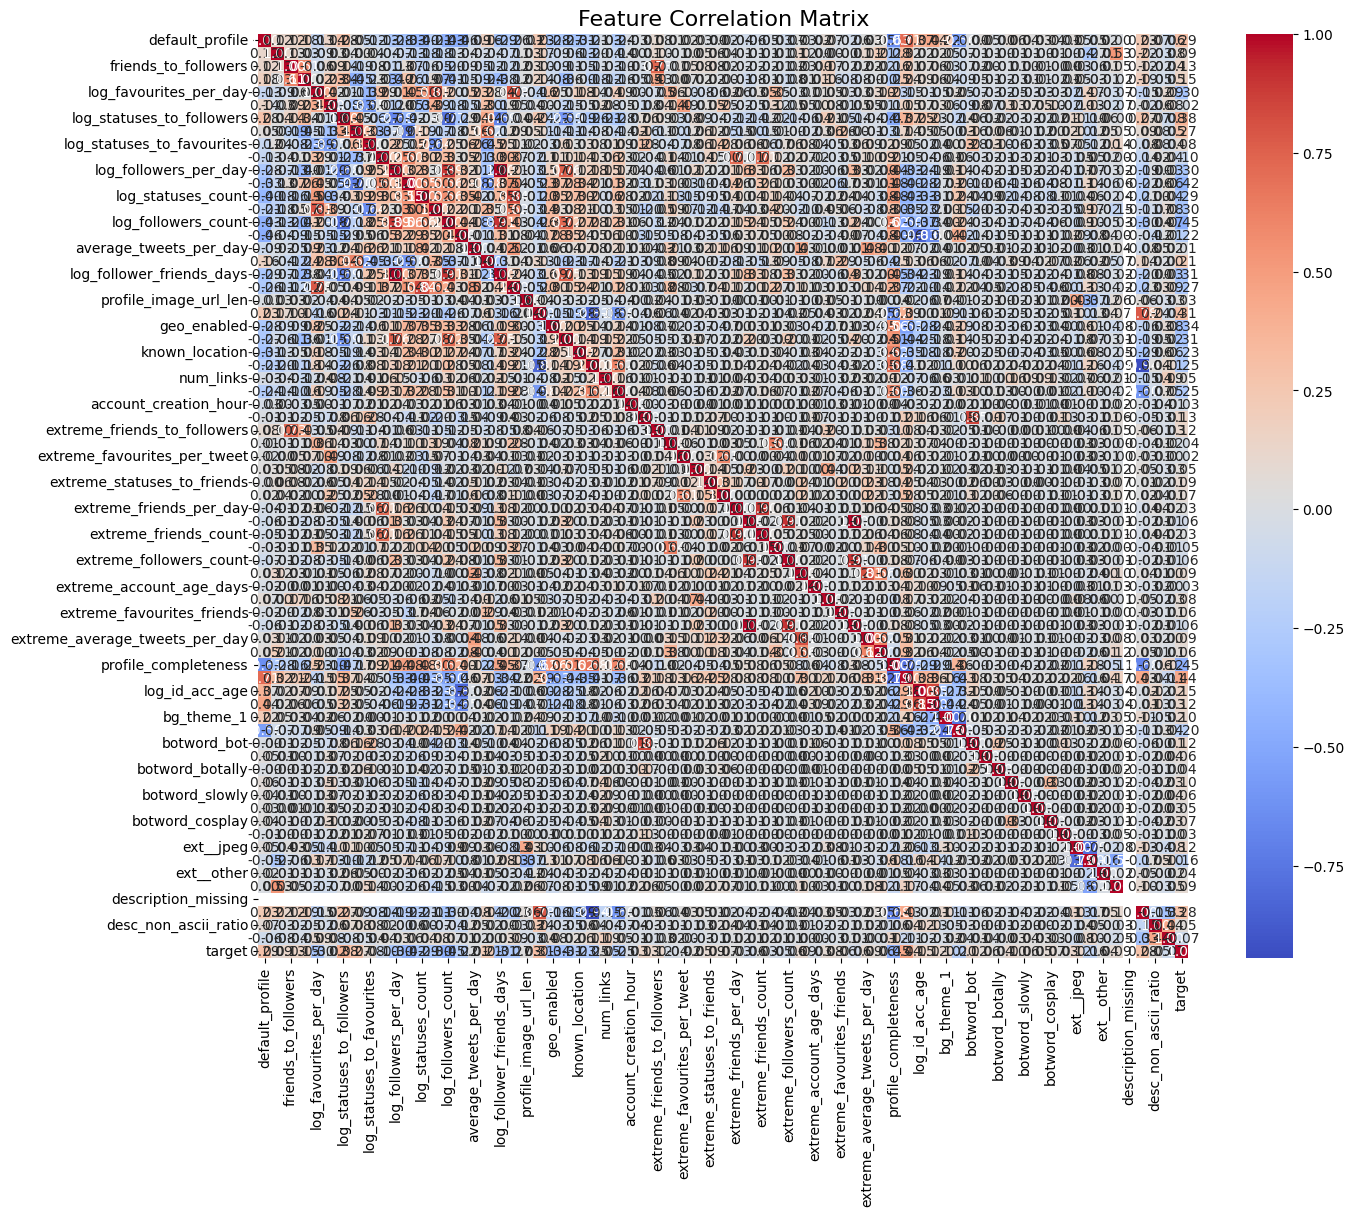

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
# ====== Compute correlation matrix ======
corr_matrix = df_train[feature_cols_train + ['target']].corr()

# ====== Plot the heatmap ======
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix", fontsize=16)
plt.show()

# Models Testing

## Logistic Regression

Accuracy: 0.8445249904616559

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      3485
           1       0.79      0.74      0.76      1757

    accuracy                           0.84      5242
   macro avg       0.83      0.82      0.82      5242
weighted avg       0.84      0.84      0.84      5242


Confusion Matrix:
 [[3134  351]
 [ 464 1293]]
ROC AUC: 0.9077335258270055


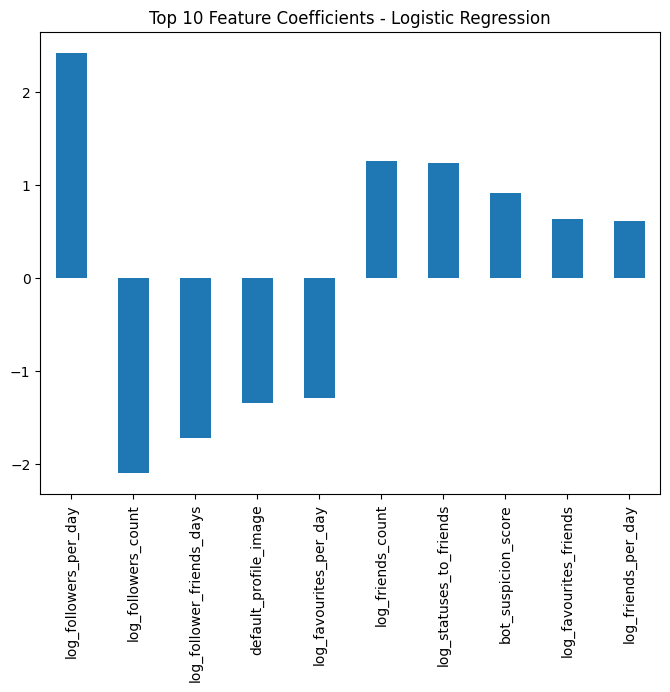

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ====== SCALING NUMERIC FEATURES ======
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

# ====== LOGISTIC REGRESSION MODEL ======
logreg = LogisticRegression(
    penalty='l2',      
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

# ====== Fit model ======
logreg.fit(X_train_scaled, y_train)

# ====== Predictions ======
y_pred = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

# ====== Evaluation ======
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
logreg_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC:", logreg_auc)

# ====== Coefficient plot ======
coef_series = pd.Series(logreg.coef_[0], index=X_train.columns).sort_values(key=abs, ascending=False)

plt.figure(figsize=(8,6))
coef_series.head(10).plot(kind='bar')
plt.title("Top 10 Feature Coefficients - Logistic Regression")
plt.show()


## Random Forest

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 12, 'bootstrap': False}
Accuracy: 0.886112170927127

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      3485
           1       0.90      0.74      0.81      1757

    accuracy                           0.89      5242
   macro avg       0.89      0.85      0.87      5242
weighted avg       0.89      0.89      0.88      5242


Confusion Matrix:
 [[3343  142]
 [ 455 1302]]
ROC AUC: 0.9442694889635963


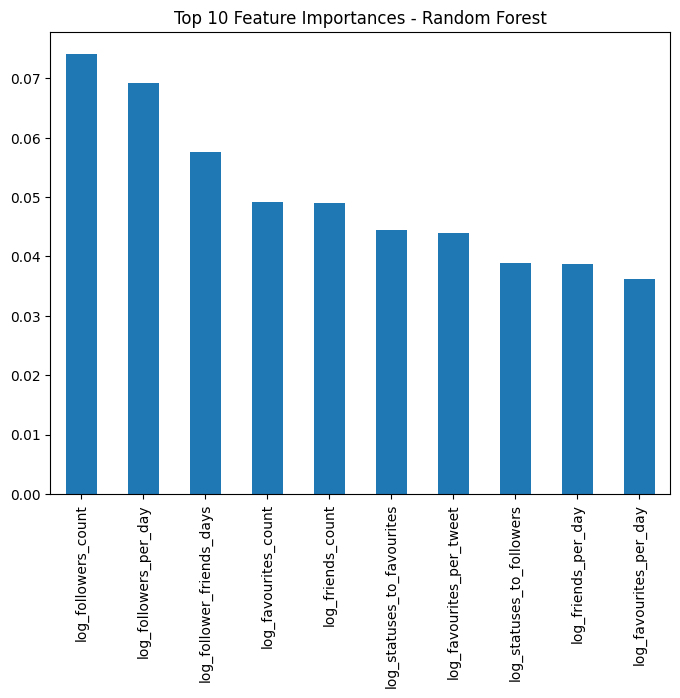

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter grid
rf_param_grid = {
    "n_estimators": [600, 800,900],
    "max_depth": [7, 9, 12],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

# Randomized Search CV
rf_search = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_param_grid,
    n_iter=5,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit model
rf_search.fit(X_train, y_train)
print("Best Parameters:", rf_search.best_params_)

# Best model
best_rf = rf_search.best_estimator_

# Predictions
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

rf_auc = roc_auc_score(y_test, y_prob_rf)
print("ROC AUC:", rf_auc)

all_features = feature_cols_train + df_train_svd.columns.tolist()

# Feature importance plot
importances = best_rf.feature_importances_
feat_importances = pd.Series(importances, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_importances.head(10).plot(kind="bar")
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()

## XGBoost

Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\gamer\OneDrive\Desktop\Y3\BT4012\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 1, 'n_estimators': 900, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.8992750858450973

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93      3485
           1       0.89      0.79      0.84      1757

    accuracy                           0.90      5242
   macro avg       0.90      0.87      0.88      5242
weighted avg       0.90      0.90      0.90      5242


Confusion Matrix:
 [[3320  165]
 [ 363 1394]]
ROC AUC: 0.9522717492399739


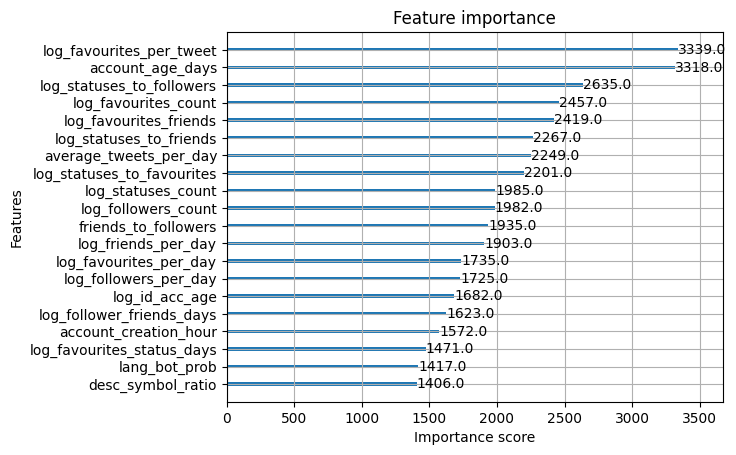

In [30]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

xgb_param_grid = {
    "n_estimators": [600, 800, 900],        
    "max_depth": [7, 9, 12],                      
    "learning_rate": [0.01, 0.03, 0.05],         
    "subsample": [0.5, 0.7, 0.9],           
    "colsample_bytree": [0.8, 0.9, 1.0],  
    "min_child_weight": [1, 3, 5],              
    "gamma": [0.3, 0.5, 1],                
    "reg_alpha": [0, 0.1, 0.5, 1],                    
    "reg_lambda": [0.5, 1, 1.5, 2]                     
}

xgb_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=5,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

xgb_search.fit(X_train, y_train)
print(xgb_search.best_params_)
best_xgb = xgb_search.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)
y_prob_xgb = best_xgb.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

xgb_auc = roc_auc_score(y_test, y_prob_xgb)
print("ROC AUC:", xgb_auc)

xgb.plot_importance(best_xgb, max_num_features=20)
plt.show()

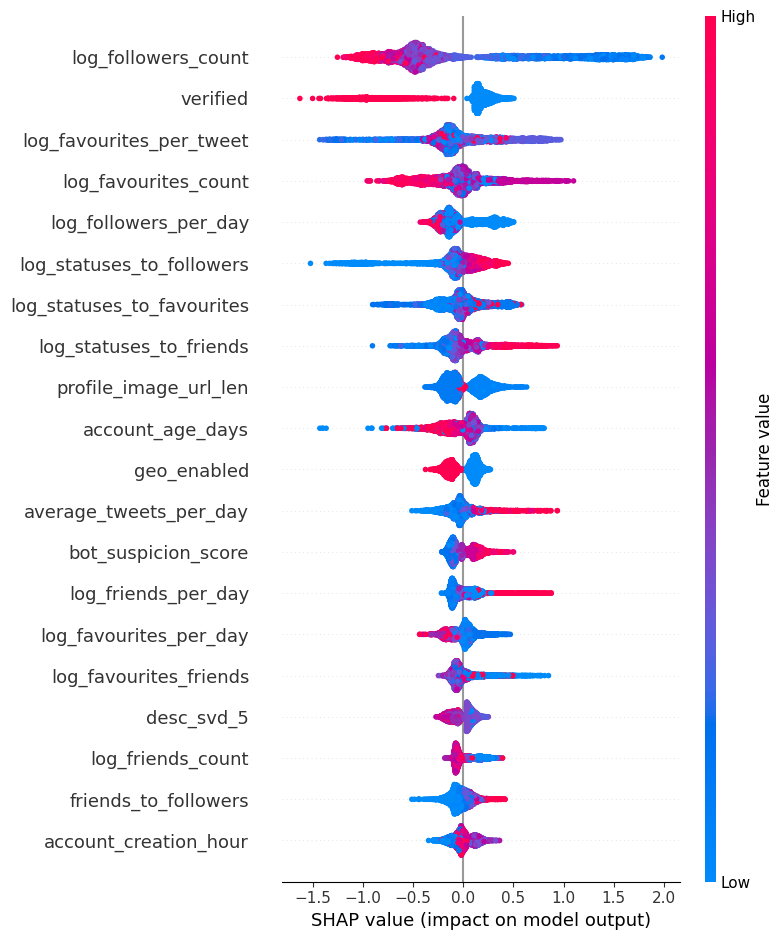

In [31]:
import shap
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)

## LightGBM

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.942686	valid_0's binary_logloss: 0.373403
[200]	valid_0's auc: 0.945952	valid_0's binary_logloss: 0.302267
[300]	valid_0's auc: 0.94844	valid_0's binary_logloss: 0.275837
[400]	valid_0's auc: 0.950121	valid_0's binary_logloss: 0.264616
[500]	valid_0's auc: 0.950919	valid_0's binary_logloss: 0.259784
[600]	valid_0's auc: 0.951585	valid_0's binary_logloss: 0.256868
[700]	valid_0's auc: 0.951846	valid_0's binary_logloss: 0.255272
[800]	valid_0's auc: 0.952101	valid_0's binary_logloss: 0.254011
[900]	valid_0's auc: 0.952151	valid_0's binary_logloss: 0.253411
[1000]	valid_0's auc: 0.95216	valid_0's binary_logloss: 0.252957
Did not meet early stopping. Best iteration is:
[980]	valid_0's auc: 0.952174	valid_0's binary_logloss: 0.253006
Best Parameters: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 1, 'num_leaves': 127, 'n_estimators': 1000, 'min_

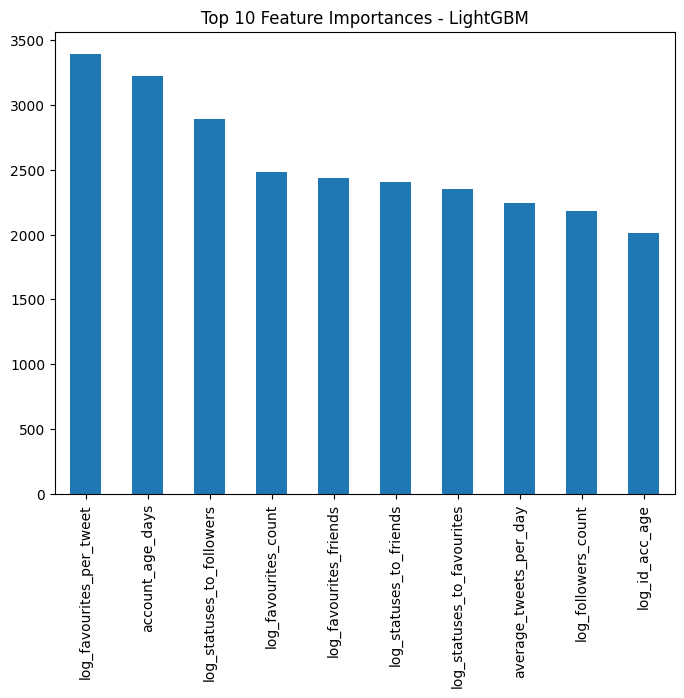

In [32]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

# LightGBM classifier
lgb_model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    n_jobs=-1,
    verbose=-1,
    random_state=42
)

# Hyperparameter grid
lgb_param_grid = {
    "num_leaves": [31, 63, 127],
    "max_depth": [7, 9, 12],
    "learning_rate": [0.01, 0.03, 0.05],
    "subsample": [0.5, 0.7, 0.9],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "min_child_weight": [1, 3, 5],
    "reg_alpha": [0, 0.1, 0.5, 1],
    "reg_lambda": [0.5, 1, 1.5, 2],
    "n_estimators": [1000]  # use large number, early stopping will determine actual boosting rounds
}

# RandomizedSearchCV
lgb_search = RandomizedSearchCV(
    lgb_model,
    param_distributions=lgb_param_grid,
    n_iter=5,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit model
lgb_search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print("Best Parameters:", lgb_search.best_params_)

# Best model
best_lgb = lgb_search.best_estimator_

# Predictions
y_pred_lgb = best_lgb.predict(X_test)
y_prob_lgb = best_lgb.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lgb))
lgb_auc = roc_auc_score(y_test, y_prob_lgb)
print("ROC AUC:", lgb_auc)

# Feature importance plot
importances = best_lgb.feature_importances_
feat_importances = pd.Series(importances, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_importances.head(10).plot(kind="bar")
plt.title("Top 10 Feature Importances - LightGBM")
plt.show()


## Stacked Model -> XGBoost, Random Forest and Logistic Regression

In [33]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Best tuned hyperparameters
best_xgb_stack = XGBClassifier(
    n_estimators=900,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda = 1.5,
    reg_alpha = 1,
    min_child_weight = 5,
    gamma = 0.3,
    random_state=42
)

best_rf_stack = RandomForestClassifier(
    n_estimators=900,
    max_depth=12,
    min_samples_split=10,
    min_samples_leaf = 4,
    max_features = 'sqrt',
    bootstrap = False,
    random_state=42,
    n_jobs=-1
)

best_logreg_stack = LogisticRegression(
    penalty='l2',      
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

# Stacked model
stack = StackingClassifier(
    estimators=[
        ('xgb', best_xgb_stack),
        ('rf', best_rf_stack),
        ('lr', best_logreg_stack)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1
)


stack.fit(X_train, y_train)

# Evaluate
y_pred_stack = stack.predict(X_test)
y_prob_stack = stack.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stack))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_stack))

stack_auc = roc_auc_score(y_test, y_prob_stack)
print("ROC AUC:", stack_auc)


Accuracy: 0.8985120183136207

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93      3485
           1       0.89      0.80      0.84      1757

    accuracy                           0.90      5242
   macro avg       0.90      0.87      0.88      5242
weighted avg       0.90      0.90      0.90      5242


Confusion Matrix:
 [[3313  172]
 [ 360 1397]]
ROC AUC: 0.9517315039901879


In [34]:
bg_theme_cols_test = [col for col in df_test.columns if col.startswith('bg_theme_')]
ext_cols_test = [col for col in df_test.columns if col.startswith('ext_')]

feature_cols_test = feature_cols + bg_theme_cols_test + bot_word_cols + ext_cols_test + structural_features + non_ascii_features

X_test = pd.concat([df_test[feature_cols_test], df_test_svd], axis=1)
y_test_pred = best_xgb.predict(X_test)
y_test_prob = best_xgb.predict_proba(X_test)[:,1]

df_test['target'] = y_test_prob

pred_df = df_test[['index', 'target']]

# Save to CSV
pred_df.to_csv("test_predictions.csv", index=False)
